In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from hydromt_sfincs import SfincsModel
from matplotlib import animation

In [2]:
# select the example model
sfincs_root = Path(r"model/base")  # (relative) path to sfincs root
model = SfincsModel(sfincs_root, mode="r")

In [3]:
model.read_results()

print(model.results.keys())

dict_keys(['inp', 'msk', 'zb', 'zs', 'zsmax', 'total_runtime', 'average_dt', 'point_zb', 'point_zs', 'crosssection_discharge'])


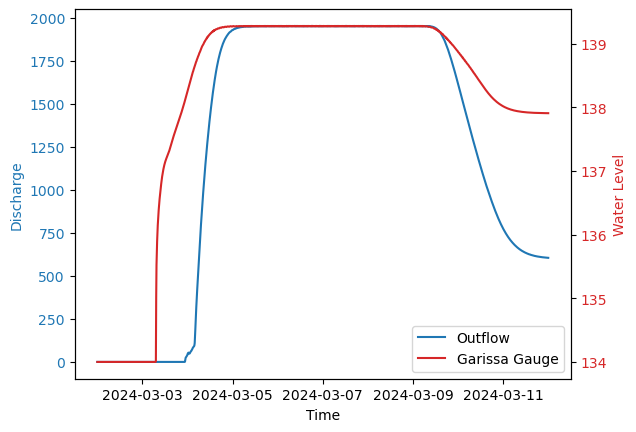

In [5]:
# Assuming model.results['crosssection_discharge'] and model.results["point_zs"] are pandas DataFrames with a 'time' column
x = model.results['crosssection_discharge']
y1 = model.results["crosssection_discharge"]*-1
y2 = model.results["point_zs"]

fig, ax1 = plt.subplots()

# Plotting discharge on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Discharge', color=color)
ax1.plot(x['time'], y1, color=color, label="Outflow")
ax1.tick_params(axis='y', labelcolor=color)

# Creating a secondary y-axis for water level
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Water Level', color=color)
ax2.plot(x['time'], y2, color=color, label="Garissa Gauge")
ax2.tick_params(axis='y', labelcolor=color)

# Adding legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

241


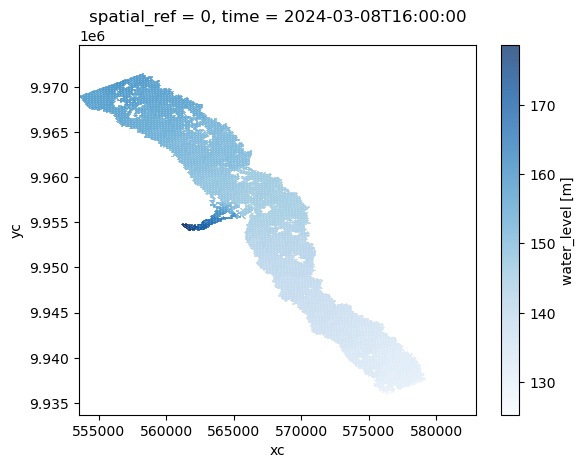

In [6]:
# _ = model.plot_basemap(variable='',bmap='sat', zoomlevel=15, plot_bounds=False)

# Amount of timesteps
t, x, y = model.results["zs"].shape
print(t)
id = 2 * t // 3

model.results["zs"][id,:,:].plot(x="xc", y="yc", cmap='Blues', alpha=0.75)
# zs is waterlevel, id is the time, vmin and vmax is the range of the waterlevel.

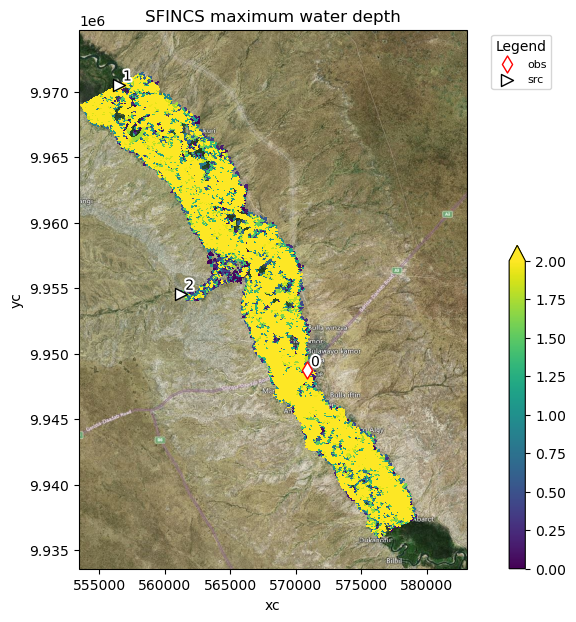

In [8]:
zs = model.results["zs"]
zsmax = zs.max(dim='time')
 
bed_level =  model.results["zb"].copy()
water_level_max = zsmax - bed_level
 
water_level_max
 
# hmax = utils.downscale_floodmap(
#     zsmax=water_level_max,
#     dep=dep, #Use subgrid
#     hmin=hmin,
#     # gdf_mask=gdf_osm,
#     # floodmap_fn=join(sfincs_root, "floodmap.tif") # uncomment to save to <mod.root>/floodmap.tif
# )
 
 
 
fig, ax = model.plot_basemap(
    fn_out=None,
    variable="", # no variable to plot, only basemap
    plot_bounds=False,
    bmap="sat",
    figsize=(11, 7),
    zoomlevel = 12
)
 
 
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
cax_fld = water_level_max.plot(
    x="xc", y="yc",
    ax=ax,
    vmin=0.0, vmax=2.0,
    cmap=plt.cm.viridis,
    cbar_kwargs=cbar_kwargs,
)
 
ax.set_title(f"SFINCS maximum water depth")
#plt.savefig(join(scenario_dir, 'hmax.png'), dpi=225, bbox_inches="tight")
plt.show() 

In [9]:
# Create quick video
da_zs = model.results["zs"].copy()

step = 1  # one frame every <step> dtout
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}

def update_plot(i, da_zs, cax_h):
    da_zs = da_zs.isel(time=i)
    t = da_zs.time.dt.strftime("%d-%B-%Y %H:%M:%S").item()
    ax.set_title(f"SFINCS water depth {t}")
    cax_h.set_array(da_zs.values.ravel())

fig, ax = model.plot_basemap(
    fn_out=None, variable="", bmap="sat", plot_bounds=False, figsize=(7, 7)
)
cax_h = da_zs.isel(time=0).plot(x="xc", y="yc", ax=ax, vmin=0, vmax=8, 
    cmap=plt.cm.Blues, alpha=0.75, cbar_kwargs=cbar_kwargs)
plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, da_zs.time.size, step),
    interval=250,  # ms between frames
    fargs=(da_zs, cax_h,),
)

# to show in notebook:
from IPython.display import HTML

HTML(ani.to_html5_video())